In [30]:
import numexpr as ne
import numpy as np
import tomocam
import tomopy
import dxchange as dx
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
import h5py
import os

In [31]:
def dXAtts(datafile, beamline='aps'):
    attrs = dict()
    fp = h5py.File(datafile, 'r')
    if beamline == 'als':
        gdata = dict(dx.reader._find_dataset_group(fp).attrs)
        attrs['pxsize']           = float(gdata['pxsize']) / 10  # /10 to convert units from mm to cm
        attrs['nslices']          = int(gdata['nslices'])
        attrs['nangles']          = int(gdata['nangles'])
        attrs['arange']           = float(gdata['arange'])
        attrs['nrays']            = int(gdata['nrays'])
        attrs['i0cycle']          = int(gdata['i0cycle'])
        attrs['num_dark_fields']  = int(gdata['num_dark_fields'])
        attrs['ind_dark']         = list(range(0, attrs['num_dark_fields']))
        attrs['num_bright_filed'] = int(gdata['num_bright_field'])
        attrs['rot_angle']        = float(gdata['rot_angle'])
    else:
        nangles, nslices, nrays = fp['exchange']['data'].shape
        attrs['nslices'] = nslices
        attrs['nangles'] = nangles
        attrs['nrays'] = nrays
    return attrs

# Input

In [32]:
filename = 'tomo_00025.h5'
inputPath = '/global/u2/d/dkumar/als/tomocam/data/tomo_00025/'
cor = 952
inputFile = os.path.join(inputPath, filename)
gdata = dXAtts(inputFile, beamline=None)
print(gdata)

{'nslices': 2048, 'nangles': 400, 'nrays': 2048}


# Output 

In [33]:
outputPath = '/global/u2/d/dkumar/als/tomocam/recon'
if not os.path.isdir(outputPath):
    os.makedirs(outputPath)
outputFile = os.path.join(outputPath, filename)

# Load data

In [34]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

sinoUsed = (gdata['nslices']//2, gdata['nslices']//2 + 8, 1)
print(sinoUsed)
proj, flat, dark, theta = dx.read_aps_2bm(inputFile, sino=sinoUsed)
proj = proj.astype(np.float32)
theta = theta.astype(np.float32)

(1024, 1032, 1)


## Normalize and minus-log

In [35]:
proj = tomopy.normalize(proj, flat, dark, out=proj)
minimum_transmission = 0.01
mx = np.float32(minimum_transmission)
ne.evaluate('where(proj>mx, proj, mx)', out=proj)
proj = tomopy.minus_log(proj)

# Remove stripes

In [36]:
proj = tomopy.prep.stripe.remove_stripe_fw(proj, level = 7, sigma = 3)

In [37]:
sino = np.transpose(proj, [1, 0, 2]).astype(np.float32)

# Reconstruct object using MBIR

In [42]:
s = 0.025   
max_iters = 300
recon = tomocam.MBIR(sino, theta, center = cor, num_iters = max_iters, smoothness = s)

Iteration:   0 , Error:  183.2111358642578
Iteration:   1 , Error:  705.6961059570312
Iteration:   2 , Error:  696.2067260742188
Iteration:   3 , Error:  684.1273803710938
Iteration:   4 , Error:  669.8463745117188
Iteration:   5 , Error:  653.2272338867188
Iteration:   6 , Error:  634.7758178710938
Iteration:   7 , Error:  614.4234619140625
Iteration:   8 , Error:  592.37646484375
Iteration:   9 , Error:  568.9515380859375
Iteration:   10 , Error:  544.076171875
Iteration:   11 , Error:  518.2130126953125
Iteration:   12 , Error:  491.2520751953125
Iteration:   13 , Error:  463.6573791503906
Iteration:   14 , Error:  435.6121826171875
Iteration:   15 , Error:  407.0618591308594
Iteration:   16 , Error:  378.3920593261719
Iteration:   17 , Error:  349.8791198730469
Iteration:   18 , Error:  321.483642578125
Iteration:   19 , Error:  293.67681884765625
Iteration:   20 , Error:  266.4101257324219
Iteration:   21 , Error:  239.86505126953125
Iteration:   22 , Error:  214.34063720703125
It

# Mask each reconstructed slice with a circle.

In [43]:
recon = tomopy.circ_mask(recon, axis=0, ratio=0.95)

# Show results

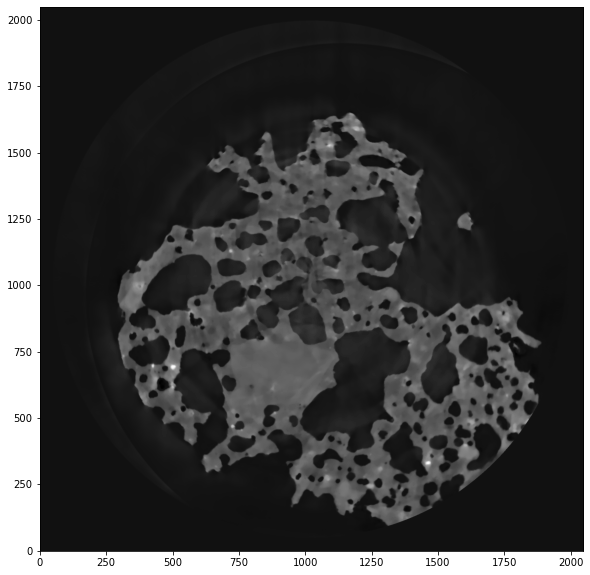

In [44]:
plt.imshow(recon[0], origin='lower', cmap='gray')

# Save to hdf5

In [45]:
with h5py.File(outputFile, 'w') as fp:
    dset = fp.create_dataset('recon', data = recon)
    dset.attrs['smoothness'] = s
    dset.attrs['num_iters'] = max_iters
    dset.attrs['remove_stripe_fw'] = 'level : 7, sigma: 3'
    dset.attrs['minimum_transmission'] = minimum_transmission